In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

csvPath = "data/"
file = "Historical Product Demand.csv"

df = pd.DataFrame(pd.read_csv(csvPath + file))
df['Date'] = pd.to_datetime(df['Date'])
df['n_Order_Demand'] = pd.to_numeric(df['Order_Demand'], errors='coerce')
print(df.head())
print('date range: ' + str(df['Date'].min()) + ' to ' + str(df['Date'].max()))


   Product_Code Warehouse Product_Category       Date Order_Demand  \
0  Product_0993    Whse_J     Category_028 2012-07-27         100    
1  Product_0979    Whse_J     Category_028 2012-01-19         500    
2  Product_0979    Whse_J     Category_028 2012-02-03         500    
3  Product_0979    Whse_J     Category_028 2012-02-09         500    
4  Product_0979    Whse_J     Category_028 2012-03-02         500    

   n_Order_Demand  
0           100.0  
1           500.0  
2           500.0  
3           500.0  
4           500.0  
date range: 2011-01-08 00:00:00 to 2017-01-09 00:00:00


Note: There are rows that has irregular format of Order_Demand, ignored them

In [2]:
df = df.dropna(subset=['n_Order_Demand'])
print(df.shape)

(1038106, 6)


# showcase the hot season of product

Some product, such as ice cream and swim suit might be popular in summer, on the other hand, swim suit and turkey may have very distinct peak of selling.

Here I am using date of year 2012 and 2016, they should look very different. But if we find some trends, then it's worth investigating. I am going to study the trends by category and by warehouse

In [3]:
df_2012 = df[df['Date'].dt.year == 2012]
df_2016 = df[df['Date'].dt.year == 2016]
print(df_2012.shape)
print(df_2016.shape)


(202278, 6)
(187734, 6)


Since the number of records varies so much, I will only focus on the categories and warehouses that exists in both year.

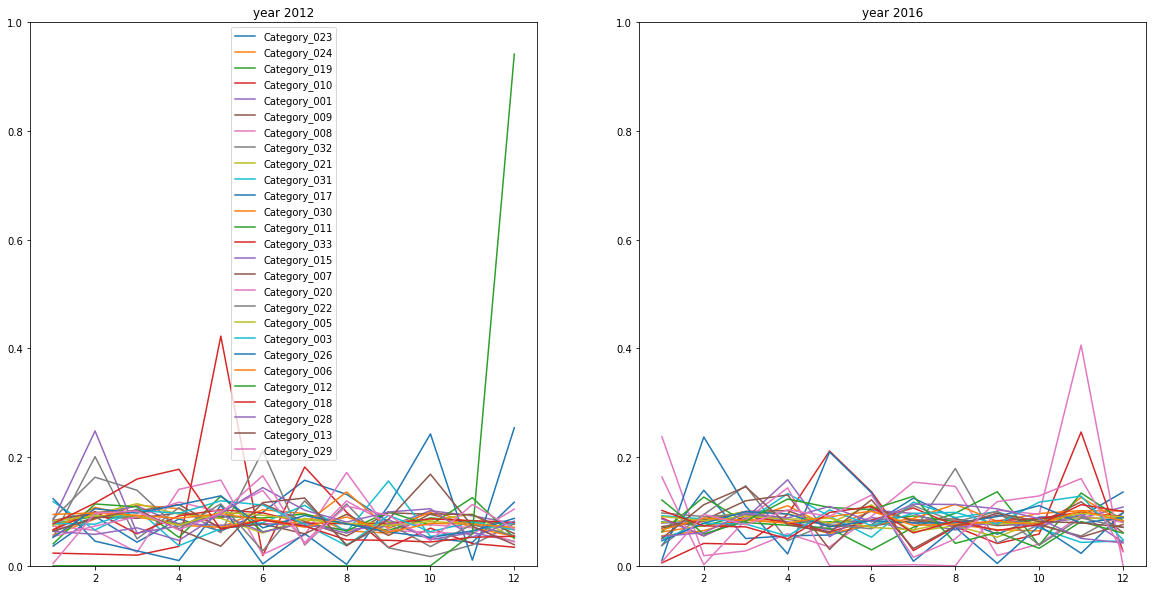

In [4]:
overlap_categories = set(df_2012['Product_Category'].unique()) & set(df_2016['Product_Category'].unique())
overlap_warehouses = set(df_2012['Warehouse'].unique())        & set(df_2016['Warehouse'].unique())
x = [1,2,3,4,5,6,7,8,9,10,11,12]
f, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True)

for c in overlap_categories:
    temp_df = df_2012[df_2012['Product_Category'] == c]
    sum_y = temp_df['n_Order_Demand'].sum()
    this_y = []
    for month in x:
        this_y.append(temp_df[temp_df['Date'].dt.month == month]['n_Order_Demand'].sum() / sum_y )
    sns.lineplot(x, this_y, label=c, ax=axes[0])
    axes[0].set_title('year 2012')
    axes[0].set_ylim([0,1])
    
    temp_df = df_2016[df_2016['Product_Category'] == c]
    sum_y = temp_df['n_Order_Demand'].sum()
    this_y = []
    for month in x:
        this_y.append(temp_df[temp_df['Date'].dt.month == month]['n_Order_Demand'].sum() / sum_y )
    sns.lineplot(x, this_y, label=c, ax=axes[1], legend=False)
    axes[1].set_title('year 2016')
    axes[1].set_ylim([0,1])

As expected, no obvious trends of Product Category, how about Warehouse?

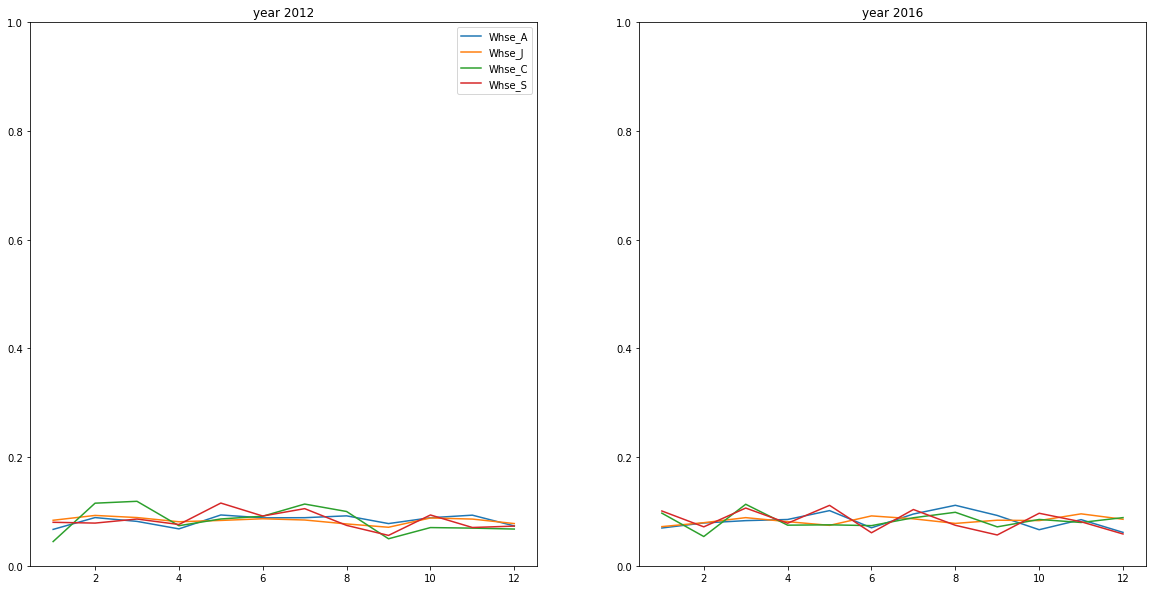

In [5]:
f, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True)

for c in overlap_warehouses:
    temp_df = df_2012[df_2012['Warehouse'] == c]
    sum_y = temp_df['n_Order_Demand'].sum()
    this_y = []
    for month in x:
        this_y.append(temp_df[temp_df['Date'].dt.month == month]['n_Order_Demand'].sum() / sum_y )
    sns.lineplot(x, this_y, label=c, ax=axes[0])
    axes[0].set_title('year 2012')
    axes[0].set_ylim([0,1])
    
    temp_df = df_2016[df_2016['Warehouse'] == c]
    sum_y = temp_df['n_Order_Demand'].sum()
    this_y = []
    for month in x:
        this_y.append(temp_df[temp_df['Date'].dt.month == month]['n_Order_Demand'].sum() / sum_y )
    sns.lineplot(x, this_y, label=c, ax=axes[1], legend=False)
    axes[1].set_title('year 2016')
    axes[1].set_ylim([0,1])

No finding either.

So I am not going to include Product_Category and Warehouse in the following time series prediction.

## Time series forecasting

For the purpose, I am using linear regression, Gradient Boosting, and NN
Use the data before 2016 to train the original model, then predict the total order_demand for each month of year 2016.

Each training sample has the previous 12 months of total order of the product. 

Here I only focus on 3 products, 'Product_0993' 'Product_0979' 'Product_1159'

In [6]:
pc_list = df['Product_Code'].unique()[0:3]
train_X = [0]*len(pc_list)
train_Y = [0]*len(pc_list)

test_X = [0]*len(pc_list)
test_Y = [0]*len(pc_list)
for pc_id in range(len(pc_list)):
    pc = pc_list[pc_id]
    series = []
    for y in [2011, 2012, 2013, 2014, 2015]:
        for m in x:
            total_order = df[(df['Product_Code'] == pc) & (df['Date'].dt.year == y) & (df['Date'].dt.month == m)]['n_Order_Demand'].sum()
            series.append(total_order)
    
    X = []
    Y = []
    p = 0
    while p+12 < len(series):
        X.append(series[p:p+12])
        Y.append(series[p+12])
        p += 1
        
    train_X[pc_id] = np.array(X)
    train_Y[pc_id] = Y
    
    series_p = []
    for y in [2016]:
        for m in x:
            total_order = df[(df['Product_Code'] == pc) & (df['Date'].dt.year == y) & (df['Date'].dt.month == m)]['n_Order_Demand'].sum()
            series_p.append(total_order)
    
    new_series = series[-12:] + series_p
    tx = []
    for i in range(len(series_p)):  
        tx.append(new_series[i:i+12])
    
    test_X[pc_id] = np.array(tx)
    test_Y[pc_id] = series_p  

## using linear regression

for Product_0993
train error: 321.0615217593815
test error:  538.323725495319
for Product_0979
train error: 26752.11293469909
test error:  35049.69424007774
for Product_1159
train error: 109428.78876695501
test error:  187215.8933684465


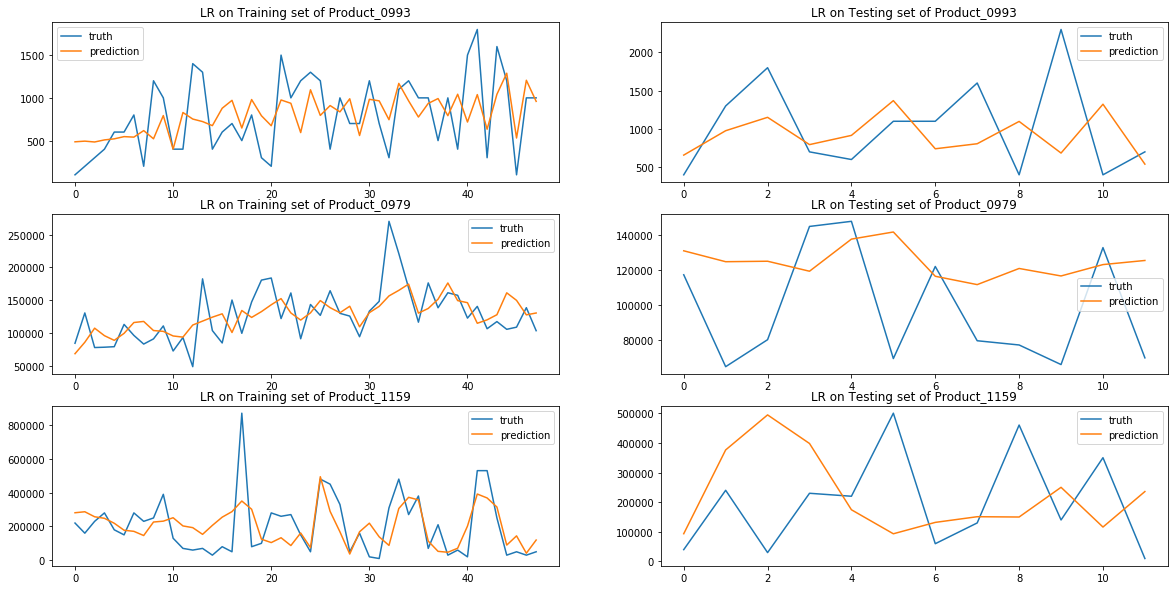

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

f, axes = plt.subplots(3, 2, figsize=(20, 10))
for pc_id in range(len(pc_list)):
    print("for " + pc_list[pc_id])
    reg = LinearRegression().fit(train_X[pc_id], train_Y[pc_id])
    
    reg_pred_train = reg.predict(train_X[pc_id])
    reg_pred_test = reg.predict(test_X[pc_id])

    print("train error: " + str(mean_absolute_error(train_Y[pc_id], reg_pred_train)))
    print("test error:  " + str(mean_absolute_error(test_Y[pc_id], reg_pred_test)))
    
    sns.lineplot(list(range(len(train_Y[pc_id]))), train_Y[pc_id], ax=axes[pc_id,0], label='truth')
    sns.lineplot(list(range(len(train_Y[pc_id]))), reg_pred_train, ax=axes[pc_id,0], label='prediction') 
    axes[pc_id,0].set_title('LR on Training set of ' + pc_list[pc_id])
    
    sns.lineplot(list(range(len(test_Y[pc_id]))), test_Y[pc_id], ax=axes[pc_id,1], label='truth')
    sns.lineplot(list(range(len(test_Y[pc_id]))), reg_pred_test, ax=axes[pc_id,1], label='prediction')
    axes[pc_id,1].set_title('LR on Testing set of ' + pc_list[pc_id])
    

for Product_0993
train error: 496.0901763319985
test error:  732.3961769112826
for Product_0979
train error: 33072.964208699064
test error:  31628.89156541645
for Product_1159
train error: 179269.40438914136
test error:  130194.16252806199


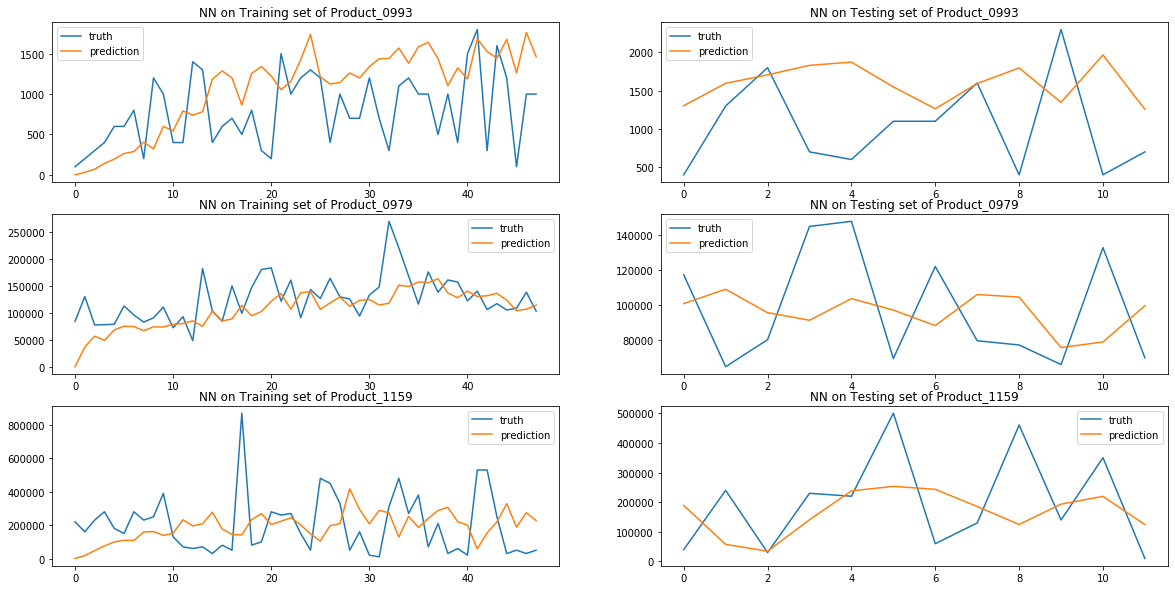

In [8]:
from sklearn.neural_network import MLPRegressor

f, axes = plt.subplots(3, 2, figsize=(20, 10))
for pc_id in range(len(pc_list)):
    print("for " + pc_list[pc_id])
    NN = MLPRegressor(learning_rate='adaptive', learning_rate_init=0.01, max_iter=1000, early_stopping=True)
    NN.fit(train_X[pc_id], train_Y[pc_id])

    NN_pred_train = NN.predict(train_X[pc_id])
    NN_pred_test = NN.predict(test_X[pc_id])
    print("train error: " + str(mean_absolute_error(train_Y[pc_id], NN_pred_train)))
    print("test error:  " + str(mean_absolute_error(test_Y[pc_id], NN_pred_test)))
    
    sns.lineplot(list(range(len(train_Y[pc_id]))), train_Y[pc_id], ax=axes[pc_id,0], label='truth')
    sns.lineplot(list(range(len(train_Y[pc_id]))), NN_pred_train, ax=axes[pc_id,0], label='prediction') 
    axes[pc_id,0].set_title('NN on Training set of ' + pc_list[pc_id])
    
    sns.lineplot(list(range(len(test_Y[pc_id]))), test_Y[pc_id], ax=axes[pc_id,1], label='truth')
    sns.lineplot(list(range(len(test_Y[pc_id]))), NN_pred_test, ax=axes[pc_id,1], label='prediction')
    axes[pc_id,1].set_title('NN on Testing set of ' + pc_list[pc_id])
  
    

for Product_0993
train error: 0.0002534976588262812
test error:  572.1405951866705
for Product_0979
train error: 0.0002635981342488473
test error:  43818.95398205246
for Product_1159
train error: 0.0006236170585225409
test error:  186531.7097850805


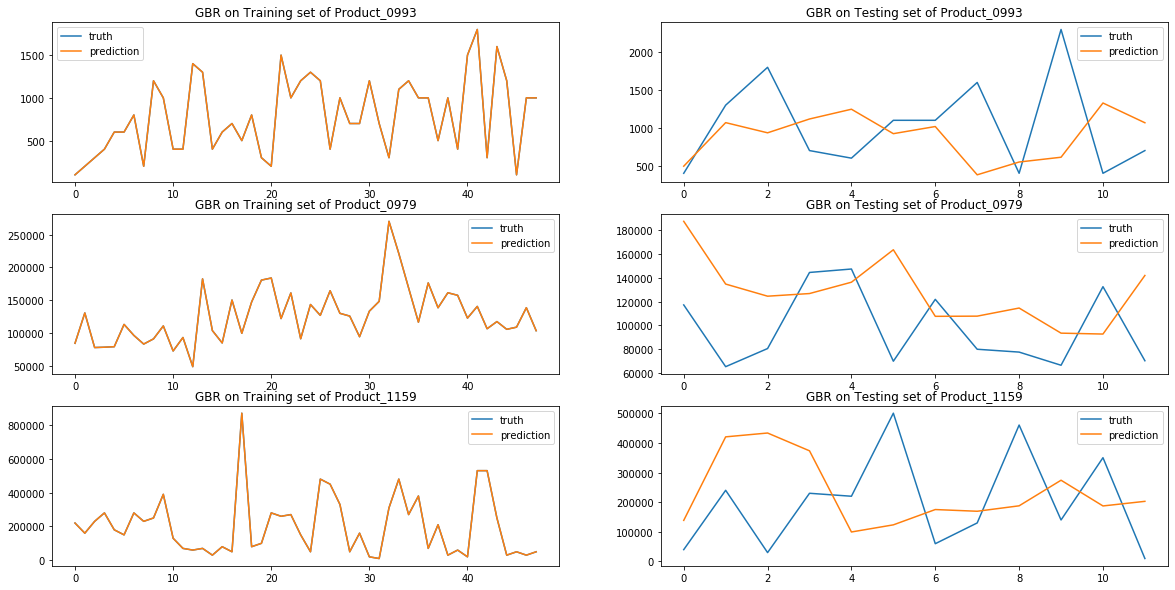

In [9]:
from sklearn.ensemble import GradientBoostingRegressor

f, axes = plt.subplots(3, 2, figsize=(20, 10))
for pc_id in range(len(pc_list)):
    print("for " + pc_list[pc_id])
    clf = GradientBoostingRegressor(n_estimators=500,max_depth=4,learning_rate=0.1)
    clf.fit(train_X[pc_id], train_Y[pc_id])
    
    clf_pred_train = clf.predict(train_X[pc_id])
    clf_pred_test = clf.predict(test_X[pc_id])
    
    print("train error: " + str(mean_absolute_error(train_Y[pc_id], clf_pred_train)))
    print("test error:  " + str(mean_absolute_error(test_Y[pc_id], clf_pred_test)))
    
    sns.lineplot(list(range(len(train_Y[pc_id]))), train_Y[pc_id], ax=axes[pc_id,0], label='truth')
    sns.lineplot(list(range(len(train_Y[pc_id]))), clf_pred_train, ax=axes[pc_id,0], label='prediction') 
    axes[pc_id,0].set_title('GBR on Training set of ' + pc_list[pc_id])
    
    sns.lineplot(list(range(len(test_Y[pc_id]))), test_Y[pc_id], ax=axes[pc_id,1], label='truth')
    sns.lineplot(list(range(len(test_Y[pc_id]))), clf_pred_test, ax=axes[pc_id,1], label='prediction')
    axes[pc_id,1].set_title('GBR on Testing set of ' + pc_list[pc_id])

Again, NN is promising but hard to tune its parameter to its best performance(not here). The interesting finding is that GradientBoostingRegressor achieves extremely low MAE on training set, yet it has similar performance as simple linear regression on test set, from the figure it's obvious that GBR is overfitting.